In [1]:
%load_ext autoreload
%autoreload 2

In [13]:
%matplotlib inline
import pickle
import pandas as pd
from tasks import wsd
from pathlib import Path
from tasks import wsd
from utils import nlp_tools
from tqdm.auto import tqdm
import numpy as np
import json
from sklearn.metrics import classification_report
from flair.embeddings import TransformerWordEmbeddings
from utils.dataset_download import harvest_data_from_extended_senses
from utils.classificaton_utils import binarize, vectorize_target_expressions,cosine_similiarity,eval_lemma

# Preparation

In [14]:
# import API credentials
with open('oed_experiments/oed_credentials.json') as f:
    auth = json.load(f)

In [15]:
# only run this once after downloading
# otherwise you remove the vectorized keywords
tqdm.pandas()
lemma,pos = 'machine', "NN"
#quotations = harvest_data_from_extended_senses(auth,f"{lemma}_{pos}")

# Vectorize data

In [16]:

quotations_path = "./data/sfrel_quotations_machine_NN.pickle"
embedding_methods = {'bert_base': {"path":'bert-base-uncased',
                                   'layers':'-1,-2,-3,-4',
                                   'pooling_operation':'mean'},
                     'blert': {"path":'/deezy_datadrive/kaspar-playground/bert_model/FT_bert_base_uncased_all_books_v002',
                                    'layers':'-1,-2,-3,-4',
                                    'pooling_operation':'mean'},
                     'bert_1850':{"path":"/datadrive/khosseini/LM_with_bert_MOVED_to_another_VM_REMOVE_FROM_NOVEMBER/models/bert/FT_bert_base_uncased_before_1850_v001", 
                                    'layers':'-1,-2,-3,-4',
                                    'pooling_operation':'mean'},
                      'bert_1900': {"path":"/datadrive/khosseini/LM_with_bert_MOVED_to_another_VM_REMOVE_FROM_NOVEMBER/models/bert/FT_bert_base_uncased_after_1890_before_1900_v002",
                                    'layers':'-1,-2,-3,-4',
                                    'pooling_operation':'mean'},
                      'bert_1875': {"path":"/datadrive/khosseini/LM_with_bert_MOVED_to_another_VM_REMOVE_FROM_NOVEMBER/models/bert/FT_bert_base_uncased_after_1850_before_1875_v002",
                                    'layers':'-1,-2,-3,-4',
                                    'pooling_operation':'mean'},
                      'bert_1890': {"path":"/datadrive/khosseini/LM_with_bert_MOVED_to_another_VM_REMOVE_FROM_NOVEMBER/models/bert/FT_bert_base_uncased_after_1875_before_1890_v002",
                                    'layers':'-1,-2,-3,-4',
                                    'pooling_operation':'mean'}
                                    }
quotations = vectorize_target_expressions(quotations_path,embedding_methods)

Dataframe alread contains vectors from bert_base settings
{'path': 'bert-base-uncased', 'layers': '-1,-2,-3,-4', 'pooling_operation': 'mean'}
Dataframe alread contains vectors from blert settings
{'path': '/deezy_datadrive/kaspar-playground/bert_model/FT_bert_base_uncased_all_books_v002', 'layers': '-1,-2,-3,-4', 'pooling_operation': 'mean'}
Dataframe alread contains vectors from bert_1850 settings
{'path': '/datadrive/khosseini/LM_with_bert_MOVED_to_another_VM_REMOVE_FROM_NOVEMBER/models/bert/FT_bert_base_uncased_before_1850_v001', 'layers': '-1,-2,-3,-4', 'pooling_operation': 'mean'}
Dataframe alread contains vectors from bert_1900 settings
{'path': '/datadrive/khosseini/LM_with_bert_MOVED_to_another_VM_REMOVE_FROM_NOVEMBER/models/bert/FT_bert_base_uncased_after_1890_before_1900_v002', 'layers': '-1,-2,-3,-4', 'pooling_operation': 'mean'}
Dataframe alread contains vectors from bert_1875 settings
{'path': '/datadrive/khosseini/LM_with_bert_MOVED_to_another_VM_REMOVE_FROM_NOVEMBER/mode

In [17]:
# inspect vectorized notebook
#df = pd.read_pickle("./data/sfrel_quotations_machine_NN.pickle")
#df.head(3)

# Disambiguation

In [18]:
senses = {'machine_nn01-38475835'} # machine_nn01-38475772 machine_nn01-38475923 machine_nn01-38475835
relations = ['seed','synonym'] # ,'descendant','sibling'
eval_mode = "lemma_etal" # lemma or lemma_etal
    

In [19]:
df_train, df_val, df_test = binarize(lemma,
                        pos,
                        senses, 
                        relations,
                        strict_filter=True,
                        start=1700,
                        end=2000,
                        eval_mode=eval_mode)

# senses before filtering by date = 517
# senses after filtering by date = 433


# of seed senses 26 
# of synonyms 383 
# of branch senses 0


# of seeds selected 1 
# of synonyms selected 2 
# of branches selected 0
[LOG] #rows before removing None vector (200, 25)
[LOG] #rows after removing None vector (200, 25)


In [20]:
vector_cols = [c for c in df_train.columns if c.startswith('vector_')]
vector_cols

['vector_bert_base_-1,-2,-3,-4_mean',
 'vector_blert_-1,-2,-3,-4_mean',
 'vector_bert_1850_-1,-2,-3,-4_mean',
 'vector_bert_1900_-1,-2,-3,-4_mean',
 'vector_bert_1875_-1,-2,-3,-4_mean',
 'vector_bert_1890_-1,-2,-3,-4_mean']

# NN Centroids
## At the binary level

In [32]:

vector_type = vector_cols[0]
centroid_vectors = df_train.groupby('label')[vector_type].apply(np.mean,axis=0)
ranking = df_test[vector_type].progress_apply(wsd.bert_binary_centroid_vector, 
                                            centroid_vectors = centroid_vectors, 
                                            return_ranking=True)
ranking

48     {'0': 0.7059285640716553, '1': 0.6714874505996...
130    {'0': 0.8326523900032043, '1': 0.6655467748641...
63     {'0': 0.7449042201042175, '1': 0.6406972408294...
174    {'0': 0.8456300497055054, '1': 0.6773621439933...
102    {'0': 0.783066987991333, '1': 0.5726575255393982}
106    {'0': 0.7439876794815063, '1': 0.613545298576355}
20     {'0': 0.7295210361480713, '1': 0.5190920829772...
194    {'0': 0.5449538230895996, '1': 0.7564820647239...
87     {'0': 0.8488082885742188, '1': 0.6256710886955...
74     {'0': 0.767792820930481, '1': 0.6032119989395142}
107    {'0': 0.7537617683410645, '1': 0.5942295789718...
151    {'0': 0.8087915182113647, '1': 0.6156530976295...
21     {'0': 0.47864437103271484, '1': 0.445715874433...
71     {'0': 0.7876814603805542, '1': 0.6219614744186...
149    {'0': 0.8424443006515503, '1': 0.6857035160064...
50     {'0': 0.7522538900375366, '1': 0.551125168800354}
88     {'0': 0.8726157546043396, '1': 0.7047543525695...
157    {'0': 0.6459929347038269

In [35]:
df_test[f"bert_nn_polar_{vector_type}"] = df_test[vector_type].progress_apply(wsd.bert_binary_centroid_vector, centroid_vectors = centroid_vectors)
wsd.eval(f"bert_nn_polar_{vector_type}",df_test)




{'1': [0.5, 1.0, 0.667], '0': [1.0, 0.919, 0.958]}

## At the sense level

In [34]:
senseid2label = dict(df_test[['sense_id','label']].values)
ranking = df_test.progress_apply(wsd.bert_sense_centroid_vector,  
                        senseid2label= senseid2label, return_ranking=True,
                        df_train = df_train, axis=1)
ranking

48     {'machine_nn01-38473945': 0.6214466691017151, ...
130    {'machine_nn01-38473945': 0.7684826850891113, ...
63     {'machine_nn01-38473945': 0.775837242603302, '...
174    {'machine_nn01-38473945': 0.7939438223838806, ...
102    {'machine_nn01-38473945': 0.7643280625343323, ...
106    {'machine_nn01-38473945': 0.6512662172317505, ...
20     {'machine_nn01-38473945': 0.7022119164466858, ...
194    {'biocomputer_nn01-11753021': 0.84155237674713...
87     {'machine_nn01-38473945': 0.8075630068778992, ...
74     {'machine_nn01-38473945': 0.7278040647506714, ...
107    {'machine_nn01-38473945': 0.7061998248100281, ...
151    {'machine_nn01-38473945': 0.7496607899665833, ...
21     {'machine_nn01-38473945': 0.4506627023220062, ...
71     {'machine_nn01-38473945': 0.7351786494255066, ...
149    {'machine_nn01-38473945': 0.8068415522575378, ...
50     {'machine_nn01-38473945': 0.6794515252113342, ...
88     {'machine_nn01-38473945': 0.8464775085449219, ...
157    {'machine_nn01-38473945'

In [33]:
senseid2label = dict(df_test[['sense_id','label']].values)
df_test[f"bert_centroid_sense_{vector_type}"] = df_test.progress_apply(wsd.bert_sense_centroid_vector,  
                        senseid2label= senseid2label,
                        df_train = df_train, axis=1)
wsd.eval(f"bert_centroid_sense_{vector_type}",df_test)

{'1': [0.75, 1.0, 0.857], '0': [1.0, 0.973, 0.986]}

# SemAxis

In [36]:
vector_type = vector_cols[0]
centroid_vectors = df_train.groupby('label')[vector_type].apply(np.mean,axis=0)
sem_axis = centroid_vectors[1] - centroid_vectors[0] 
sims = df_val[vector_type].progress_apply(wsd.bert_semaxis_vector, sem_axis=sem_axis, return_ranking=True)

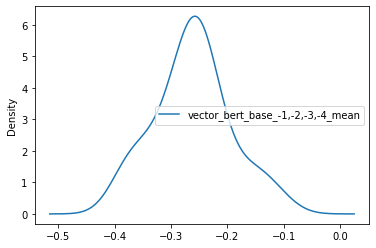

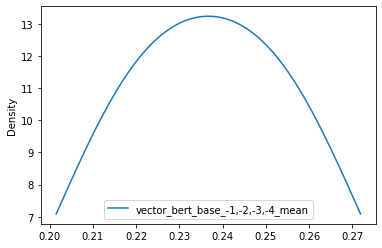

In [41]:
dfL = pd.DataFrame([sims,df_val.label]).T
dfL[dfL.label=="0"].plot(kind='density')
dfL[dfL.label=="1"].plot(kind='density')

In [42]:
df_test[f"bert_contrast_{vector_type}"] = df_test[vector_type].progress_apply(wsd.bert_semaxis_vector,
                                                    sem_axis=sem_axis,
                                                    threshold=.0)
wsd.eval(f"bert_contrast_{vector_type}",df_test)

{'1': [0.5, 1.0, 0.667], '0': [1.0, 0.919, 0.958]}

# Time sensitive

In [60]:
ranking = df_test.progress_apply(wsd.bert_ts_binary_centroid_vector, 
                                df_train=df_train, 
                                return_ranking=True, 
                                ts_method='weighted',
                                axis=1)
ranking


48     {'0': 0.7285661101341248, '1': 0.6312580108642...
130    {'0': 0.830029308795929, '1': 0.6994504928588867}
63     {'0': 0.791853666305542, '1': 0.6461601853370667}
174    {'0': 0.8632854223251343, '1': 0.7023310661315...
102    {'0': 0.8019722104072571, '1': 0.5857865214347...
106    {'0': 0.7227280735969543, '1': 0.616225004196167}
20     {'0': 0.6942027807235718, '1': 0.6270302534103...
194     {'0': 0.52796870470047, '1': 0.7265188097953796}
87     {'0': 0.8429628610610962, '1': 0.6334317326545...
74     {'0': 0.7789071202278137, '1': 0.6116113662719...
107    {'0': 0.7457500696182251, '1': 0.6065853238105...
151    {'0': 0.8123207688331604, '1': 0.633213996887207}
21     {'0': 0.5040832161903381, '1': 0.4442103207111...
71     {'0': 0.7709633111953735, '1': 0.6255887746810...
149    {'0': 0.8313402533531189, '1': 0.6970073580741...
50     {'0': 0.712952733039856, '1': 0.4917427599430084}
88     {'0': 0.8596712946891785, '1': 0.711310088634491}
157    {'0': 0.621320366859436,

In [57]:
df_test[f"bert_ts_nn_polar_{vector_type}"] = df_test.progress_apply(wsd.bert_ts_binary_centroid_vector, 
                                                        df_train=df_train, 
                                                        ts_method='weighted',
                                                        axis=1)
wsd.eval(f"bert_ts_nn_polar_{vector_type}",df_test)

{'1': [0.5, 1.0, 0.667], '0': [1.0, 0.919, 0.958]}

In [39]:
#df_test[f"bert_ts_nn_polar_{vector_type}"] = df_test.progress_apply(wsd.bert_ts_semaxis_vector, df_train=df_train, axis=1)
#wsd.eval(f"bert_ts_nn_polar_{vector_type}",df_test)

{'1': [0.0, 0.0, 0.0], '0': [0.904, 1.0, 0.949]}

## At the sense level

In [62]:
senseid2label = dict(df_test[['sense_id','label']].values)
ranking = df_test.progress_apply(wsd.bert_ts_sense_centroid_vector,  
                        senseid2label= senseid2label,
                        ts_method='nearest_in_time',
                        return_ranking=True,
                        df_train = df_train, axis=1)
ranking 

48     {'machine_nn01-38473945': 0.6052708625793457, ...
130    {'machine_nn01-38473945': 0.7032647132873535, ...
63     {'machine_nn01-38473945': 0.5851057767868042, ...
174    {'machine_nn01-38473945': 0.6916408538818359, ...
102    {'machine_nn01-38473945': 0.575348436832428, '...
106    {'machine_nn01-38473945': 0.5598823428153992, ...
20     {'machine_nn01-38473945': 0.5434926748275757, ...
194    {'biocomputer_nn01-11753021': 0.80939692258834...
87     {'machine_nn01-38473945': 0.7461997866630554, ...
74     {'machine_nn01-38473945': 0.6296086311340332, ...
107    {'machine_nn01-38473945': 0.6221022605895996, ...
151    {'machine_nn01-38473945': 0.7107853889465332, ...
21     {'machine_nn01-38473945': 0.3386283218860626, ...
71     {'machine_nn01-38473945': 0.6119284629821777, ...
149    {'machine_nn01-38473945': 0.6607771515846252, ...
50     {'machine_nn01-38473945': 0.5646792054176331, ...
88     {'machine_nn01-38473945': 0.7568649053573608, ...
157    {'machine_nn01-38473945'

In [63]:
senseid2label = dict(df_test[['sense_id','label']].values)
df_test[f"bert_centroid_sense_{vector_type}"] = df_test.progress_apply(wsd.bert_ts_sense_centroid_vector,  
                        senseid2label= senseid2label,
                        ts_method='nearest_in_time',
                        df_train = df_train, axis=1)

wsd.eval(f"bert_centroid_sense_{vector_type}",df_test)


{'1': [1.0, 1.0, 1.0], '0': [1.0, 1.0, 1.0]}

# Eval at the lemma level

In [5]:

embedding_methods = {'bert_base': {"path":'bert-base-uncased',
                                   'layers':'-1,-2,-3,-4',
                                   'pooling_operation':'mean'},
                     'blert': {"path":'/deezy_datadrive/kaspar-playground/bert_model/FT_bert_base_uncased_all_books_v002',
                                    'layers':'-1,-2,-3,-4',
                                    'pooling_operation':'mean'},
                     'bert_1850':{"path":"/datadrive/khosseini/LM_with_bert_MOVED_to_another_VM_REMOVE_FROM_NOVEMBER/models/bert/FT_bert_base_uncased_before_1850_v001", 
                                    'layers':'-1,-2,-3,-4',
                                    'pooling_operation':'mean'},
                      'bert_1900': {"path":"/datadrive/khosseini/LM_with_bert_MOVED_to_another_VM_REMOVE_FROM_NOVEMBER/models/bert/FT_bert_base_uncased_after_1890_before_1900_v002",
                                    'layers':'-1,-2,-3,-4',
                                    'pooling_operation':'mean'},
                      'bert_1875': {"path":"/datadrive/khosseini/LM_with_bert_MOVED_to_another_VM_REMOVE_FROM_NOVEMBER/models/bert/FT_bert_base_uncased_after_1850_before_1875_v002",
                                    'layers':'-1,-2,-3,-4',
                                    'pooling_operation':'mean'},
                      'bert_1890': {"path":"/datadrive/khosseini/LM_with_bert_MOVED_to_another_VM_REMOVE_FROM_NOVEMBER/models/bert/FT_bert_base_uncased_after_1875_before_1890_v002",
                                    'layers':'-1,-2,-3,-4',
                                    'pooling_operation':'mean'}
                                    }


In [8]:
y_true, y_pred_bin_centr,y_pred_ts_bin_centr,y_pred_sense_centr,y_pred_semaxis,rand, token_overlap, w2v_lesk = eval_lemma('machine','NN','01',embedding_methods,vector_type='vector_bert_base_-1,-2,-3,-4_mean')


machine_nn01-38475923
# senses before filtering by date = 517
# senses after filtering by date = 352


# of seed senses 22 
# of synonyms 310 
# of branch senses 0


# of seeds selected 1 
# of synonyms selected 8 
# of branches selected 0
[LOG] #rows before removing None vector (263, 25)
[LOG] #rows after removing None vector (263, 25)
100%|██████████| 53/53 [00:00<00:00, 26226.77it/s]
Using lemma_etal as evaluation mode.
100%|██████████| 53/53 [00:00<00:00, 7994.61it/s]
machine_nn01-38474301
# senses before filtering by date = 517
# senses after filtering by date = 352


# of seed senses 22 
# of synonyms 310 
# of branch senses 0


# of seeds selected 1 
# of synonyms selected 3 
# of branches selected 0
[LOG] #rows before removing None vector (152, 25)
[LOG] #rows after removing None vector (152, 25)
100%|██████████| 31/31 [00:00<00:00, 6533.51it/s]
machine_nn01-38474140
# senses before filtering by date = 517
# senses after filtering by date = 352


# of seed senses 22 
# of synon

In [9]:
print(classification_report(y_true, rand))

              precision    recall  f1-score   support

           0       0.91      0.48      0.63      1616
           1       0.10      0.56      0.17       170

    accuracy                           0.49      1786
   macro avg       0.51      0.52      0.40      1786
weighted avg       0.83      0.49      0.59      1786



In [10]:
print(classification_report(y_true, token_overlap))

              precision    recall  f1-score   support

           0       0.93      0.86      0.89      1616
           1       0.20      0.35      0.26       170

    accuracy                           0.81      1786
   macro avg       0.57      0.60      0.57      1786
weighted avg       0.86      0.81      0.83      1786



In [11]:
print(classification_report(y_true, w2v_lesk))

              precision    recall  f1-score   support

           0       0.94      0.88      0.91      1616
           1       0.28      0.47      0.35       170

    accuracy                           0.84      1786
   macro avg       0.61      0.67      0.63      1786
weighted avg       0.88      0.84      0.85      1786



In [21]:
    print(classification_report(y_true, y_pred_bin_centr))

              precision    recall  f1-score   support

           0       0.96      0.80      0.87      1616
           1       0.25      0.66      0.37       170

    accuracy                           0.78      1786
   macro avg       0.61      0.73      0.62      1786
weighted avg       0.89      0.78      0.82      1786



In [22]:
print(classification_report(y_true, y_pred_ts_bin_centr))

              precision    recall  f1-score   support

           0       0.94      0.84      0.88      1616
           1       0.23      0.46      0.31       170

    accuracy                           0.80      1786
   macro avg       0.58      0.65      0.60      1786
weighted avg       0.87      0.80      0.83      1786



In [23]:
print(classification_report(y_true, y_pred_sense_centr ))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96      1616
           1       0.59      0.45      0.51       170

    accuracy                           0.92      1786
   macro avg       0.77      0.71      0.73      1786
weighted avg       0.91      0.92      0.91      1786



In [34]:
print(classification_report(y_true,y_pred_semaxis ))

              precision    recall  f1-score   support

           0       0.96      0.69      0.80      1616
           1       0.20      0.73      0.31       170

    accuracy                           0.70      1786
   macro avg       0.58      0.71      0.56      1786
weighted avg       0.89      0.70      0.76      1786

